## Example of Trans-C sampling across independent model states

This notebook demonstrates sampling across unormalized multi-dimensional Gaussian PDFs in states with non-consequtive dimensions
using the Ensemble resampler.

In [13]:
# general python utility packages
import time
from collections import Counter
from functools import partial

import corner
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

In [14]:
from pytransc.analysis.laplace import run_laplace_evidence_approximation
from pytransc.analysis.samples import resample_ensembles
from pytransc.analysis.visits import (
    count_state_changes,
    count_total_state_changes,
    get_acceptance_rate_between_states,
    get_autocorr_between_state_jumps,
    get_relative_marginal_likelihoods,
    get_visits_to_states,
)
from pytransc.samplers import run_ensemble_resampler, run_mcmc_per_state
from pytransc.utils.auto_pseudo import build_auto_pseudo_prior

--------

## Example set up: Three states with non-consecutive dimensions, 3D, 5D and 10D Gaussians

Set some global control parameters for all examples.

In [15]:
plotting = True  # Create some diagnostic displays of outputs
parallel = False  # Use parallel computation for sampling
autopseudo = True  # Use automatic generation of pseudo-prior function, as alternate to user specified Gaussian.
autothin = False  # Thin internally generated within state posterior ensembles by their auto-correlation
# (This can take additional compute time, and is not necessary if input ensembles are already independent.)

Define log posterior PDF for three states with Gaussian posterior PDF.

First we set up three unormalized Gaussian states.

In [16]:
# Set up PDFs in each state
nstates = 3  # Number of states
ndims = [3, 5, 10]  # Number of dimensions for each state
weights = [
    0.56,
    0.3,
    0.14,
]  # weights for each state (become true values for relative evidence/marginal Likelihoods.
trueML = weights / np.sum(
    weights
)  # true values of marginal Likelihoods/relative evidences
mu = [
    [0.8, 0.8, 0.8],
    [0.3 for i in range(5)],
    [0.5 for i in range(10)],
]  # Gaussian means for each state
sig = [0.02, 0.05, 0.08]  # standard deviations of Gaussians in each state
cov = [
    np.diag(np.ones(ndims[i]) * sig[i] ** 2) for i in range(nstates)
]  # covariance matrices for each state
if True:  # rotate the covariance matrices
    np.random.seed(210165)  # noqa: NPY002
    new_cov = []
    for i in range(nstates):
        rotation_matrix = np.random.rand(ndims[i], ndims[i]) - 0.5  # noqa: NPY002
        new_cov.append(rotation_matrix @ cov[i] @ rotation_matrix.T)
    cov = new_cov
icov = [
    np.linalg.inv(cov[0]),
    np.linalg.inv(cov[1]),
    np.linalg.inv(cov[2]),
]  # inverse covariance matrices for each state

### Log-posterior PDF
Define log_posterior function using these Gaussian PDFs.

In [17]:
def _log_posterior(x, state, ndims, mu, cov, weights, icov=False):
    """Multi-state log Posterior PDF evaluation (unormalised) for three multi-dimensional Gaussians."""
    w = weights[state]
    mean = mu[state]
    covar = cov[state]
    r = mean - x
    if icov:
        if ndims[state] == 1:
            log_const = (
                np.log(w) - 0.5 * len(x) * np.log(2 * np.pi) - 0.5 * np.log(covar[0])
            )
            out = log_const - 0.5 * np.dot(r, r) * (covar[0])
        else:
            log_const = (
                np.log(w)
                - 0.5 * len(x) * np.log(2 * np.pi)
                - 0.5 * np.log(np.linalg.det(covar))
            )
            out = log_const - 0.5 * np.dot(r, np.dot(covar, r))
    else:
        if ndims[state] == 1:
            log_const = (
                np.log(w) - 0.5 * len(x) * np.log(2 * np.pi) - 0.5 * np.log(covar[0])
            )
            out = log_const - 0.5 * np.dot(r, r) / (covar[0])
        else:
            log_const = (
                np.log(w)
                - 0.5 * len(x) * np.log(2 * np.pi)
                - 0.5 * np.log(np.linalg.det(covar))
            )
            out = log_const - 0.5 * np.dot(r, np.linalg.solve(covar, r))
    return out


log_posterior = partial(_log_posterior, ndims=ndims, mu=mu, cov=cov, weights=weights)

### Starting points for MCMC samplers

In [18]:
# first we optimize each state to find good starting point for all McMC samplers
rng = np.random.default_rng(42)
nll = lambda *args: -log_posterior(*args)
initial = np.array([0.5])
ml = []
print("Maximum likelihood estimates:")
for i in range(nstates):
    soln = minimize(nll, initial, args=(i,))
    ml.append(soln.x)
    print(f"x_ml = {soln.x[0]:.3f}")

Maximum likelihood estimates:
x_ml = 0.800
x_ml = 0.300
x_ml = 0.500


-----------

Now we are ready to apply the three algorithms to sampling over the model states.

## Trans-C sampling across posterior ensembles, using the ensemble resampler

Calculate marginal Likelihoods across states using ensemble sampler algorithm.

### Preliminaries 

#### Build posterior ensembles in each state

We need to either read in or build posterior ensembles in each state. Here we generate them with a standard MCMC sampler.

First we optimize each state to find a good starting point for McMC sampler

Set up input choices for MCMC sampler.

In [19]:
# setup of MCMC sampler
nsamples = [
    50000,
    50000,
    50000,
]  # number of samples per chain for sampling of each state
nwalkers = [32, 32, 32]  # number of mcmc chains to run simultaneously in each state
pos = []
for i in range(nstates):  # generate starting points for each chain in each state
    pos.append(
        ml[i] + 1e-4 * rng.standard_normal((nwalkers[i], ndims[i]))
    )  # add random perturbation to maximum Likelihood models

Run MCMC in each state separately.

In [20]:
# first step: run Ensemble sampler in each state

start_time = time.time()
ensemble_per_state, log_posterior_ens = run_mcmc_per_state(
    nstates,  # number of states
    ndims,  # number of dimensions in each state
    nwalkers,  # int or list containing number of walkers for each state
    nsamples,  # number of chain steps per walker
    pos,  # starting positions for walkers in each state
    log_posterior,  # log Likelihood x log_prior
    discard=0,  # burnin number of chain steps to discard in eeach state
    auto_thin=True,  # thinning value, save every `thin` models
    verbose=True,
)
elapsed_time = time.time() - start_time

print(
    " Elapsed time                                     :",
    np.round(elapsed_time, 2),
    "s \n",
)
print(
    " Number of samples in each state                  :",
    *[len(ensemble_per_state[i]) for i in range(nstates)],
)


Running within-state sampler separately on each state

Number of walkers               :  [32, 32, 32]

Number of states being sampled:  3
Dimensions of each state:  [3, 5, 10]


100%|████████████████████████████████████████████████████████████| 50000/50000 [00:18<00:00, 2643.20it/s]


Performing auto thinning of ensemble...
 Elapsed time                                     : 59.83 s 

 Number of samples in each state                  : 79996 53330 28066


#### Build pseudo priors by fitting a Gaussian mixture to posterior ensembles in each state

Fit a mixture model in each state to create an automatic pseudo prior, and then evaluate that pseudo_prior for all points in the ensembles. This uses the posterior ensembles `ensemble_per_state[s],s=1,...,nstates`  and produces an ensemble of log-pseudo-prior values which are placed in `log_pseudo_prior_ens[s],s=1,...,nstates`. These are then provided to the ensemble resampler `run_ensemble_resampler`.

In [9]:
# fit a mixture model to each state to get a normalized pseudo prior PDF.

log_pseudo_prior = build_auto_pseudo_prior(
    ensemble_per_state=ensemble_per_state, reg_covar=0.0
)
log_pseudo_prior_ens = []
for i, ens in enumerate(ensemble_per_state):
    log_pseudo_prior_ens.append(np.array([log_pseudo_prior(x, i) for x in ens]))

Plot input samples in corner plot for reference.

 State;  0  in  3  dimensions
 State;  1  in  5  dimensions
 State;  2  in  10  dimensions


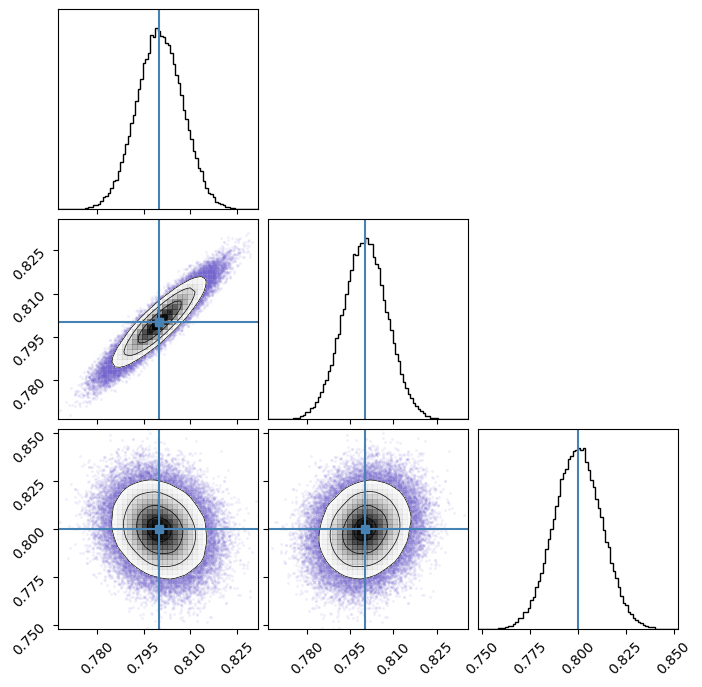

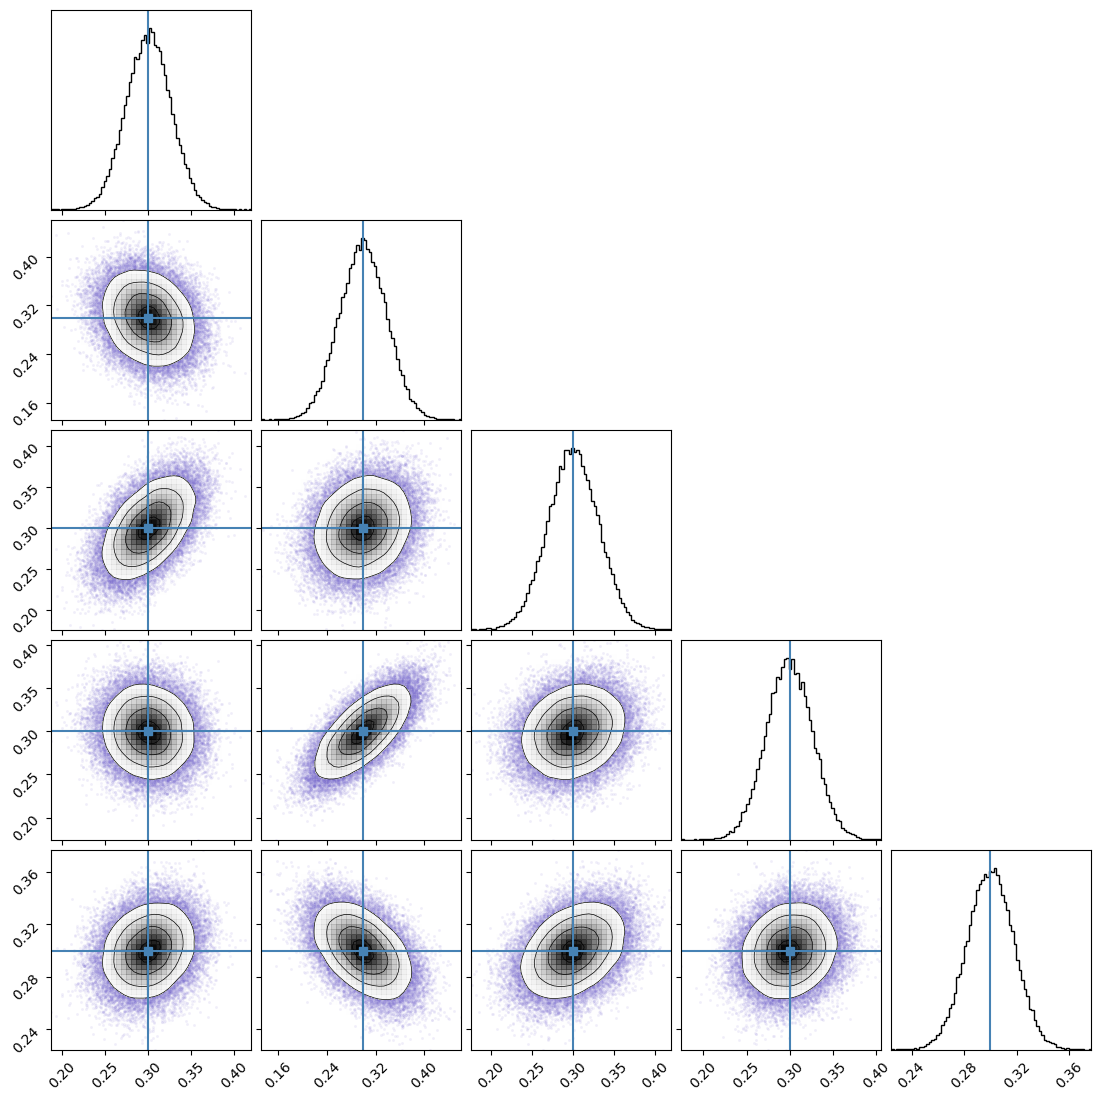

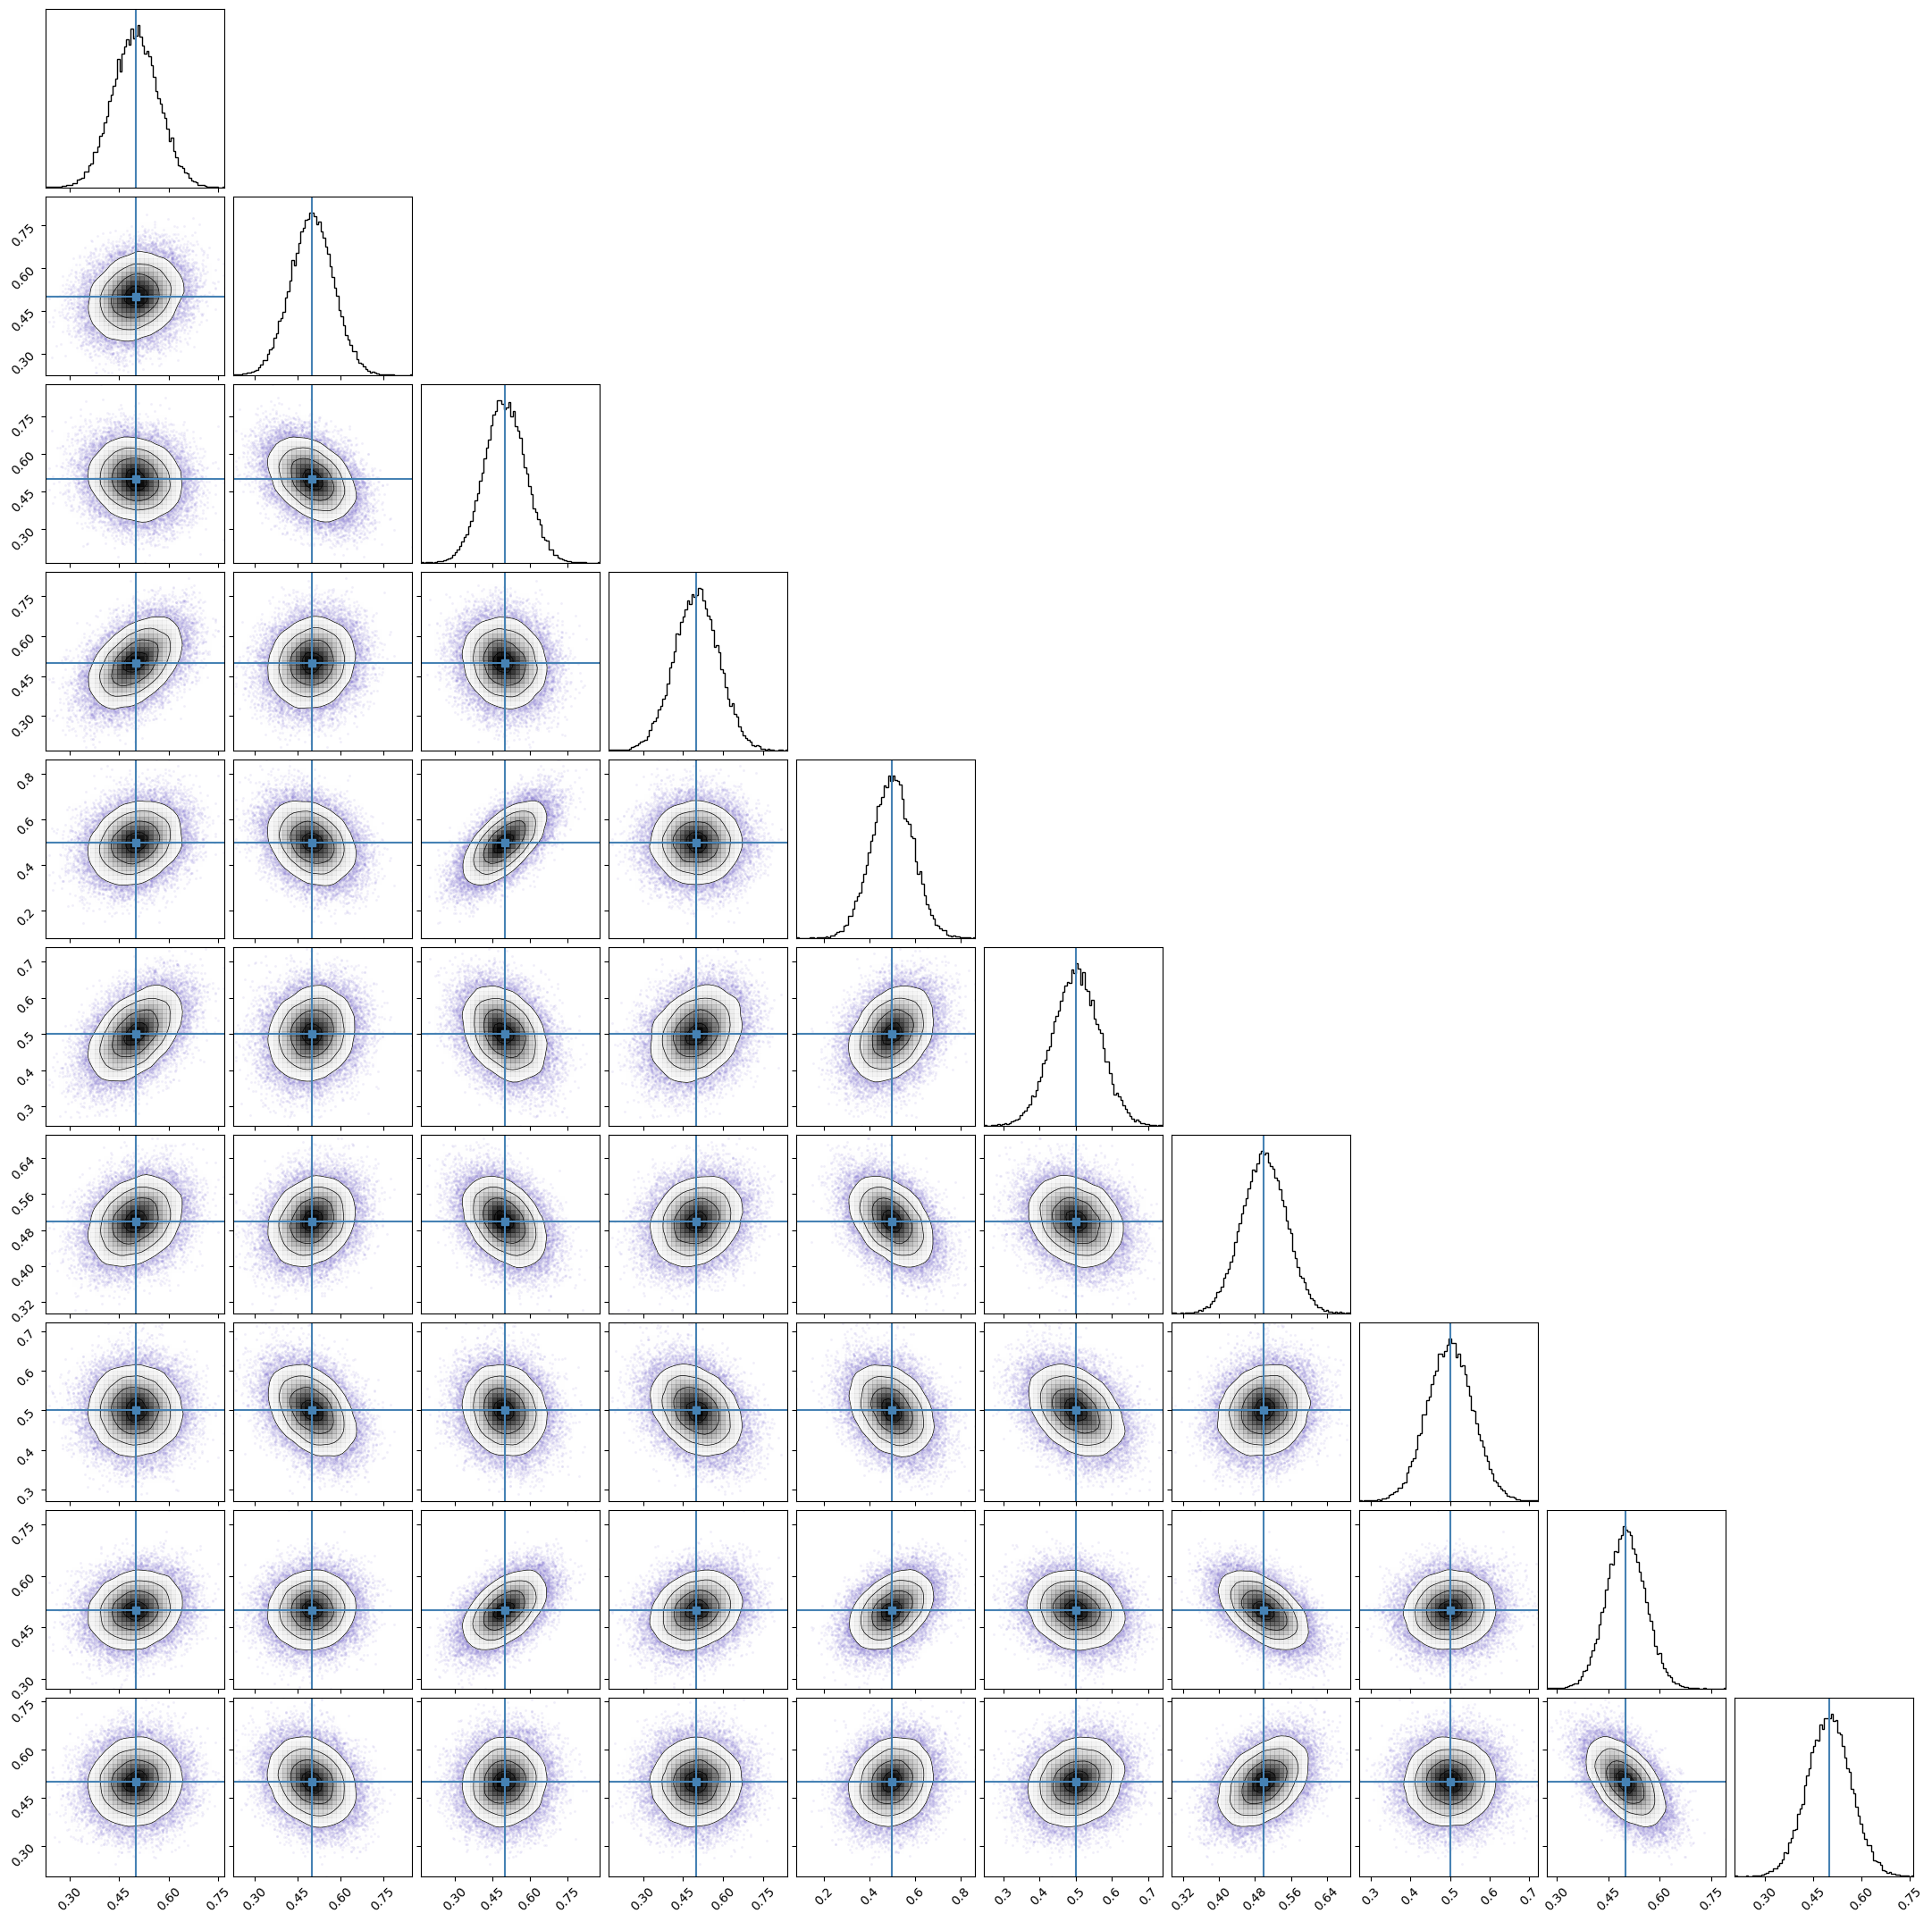

In [10]:
# corner plots to check sampling within each state
if plotting:
    contour_kwargs = {"linewidths": 0.5}
    data_kwargs = {"color": "darkblue"}
    data_kwargs = {"color": "slateblue"}
    for i in range(nstates):
        string = "State " + str(i)
        print(" State; ", i, " in ", ndims[i], " dimensions")
        fig = corner.corner(
            ensemble_per_state[i],
            truths=mu[i],
            title=string,
            bins=40,
            hist_bin_factor=2,
            smooth=True,
            contour_kwargs=contour_kwargs,
            data_kwargs=data_kwargs,
        )

In [21]:
# Calculate marginal Likelihoods using ensembles for each state
nwalkers = 32  # number of independent random walkers across ensembles
nsteps = 100000  # number of chain steps for each walker
start_time = time.time()
resampler_chains = run_ensemble_resampler(
    nwalkers,
    nsteps,
    nstates,
    ndims,
    log_posterior_ens=log_posterior_ens,
    log_pseudo_prior_ens=log_pseudo_prior_ens,    progress=True,
)  # run mcmc sampler over ensembles to get marginal Likelihoods between states
elapsed_time = time.time() - start_time

alg = "TransC-ensemble-resampler"
state_chain_tot = np.swapaxes(resampler_chains.state_chain_tot, 0, 1)
state_chain = resampler_chains.state_chain.T
accept_within_per_walker = 1.0 * np.ones(nwalkers)
accept_between_per_walker = resampler_chains.n_accepted / nsteps
accept_within = 100 * np.mean(accept_within_per_walker)
accept_between = 100 * np.mean(accept_between_per_walker)
nsamples = [len(a) for a in log_posterior_ens]

2025-10-15 12:00:00 [INFO] pytransc.samplers.ensemble_resampler: 
Running ensemble resampler
2025-10-15 12:00:00 [INFO] pytransc.samplers.ensemble_resampler: 
Number of walkers               : 32
2025-10-15 12:00:00 [INFO] pytransc.samplers.ensemble_resampler: Number of states being sampled  : 3
2025-10-15 12:00:00 [INFO] pytransc.samplers.ensemble_resampler: Dimensions of each state        : [3, 5, 10]
100%|████████████████████████████████████████████████████████████████████| 32/32 [00:17<00:00,  1.81it/s]


In [14]:
# print some diagnostics
print("\n Algorithm type                                      :", alg)
print(
    " Average % acceptance rate for within states         :",
    np.round(accept_within, 2),
)
print(
    " Average % acceptance rate for between states        :",
    np.round(accept_between, 2),
)

# extract trans-D samples and chains
discard = 0  # chain burnin
thin = 15  # chain thinning
visits, states_chain = get_visits_to_states(
    transc_sampler=resampler_chains,
    discard=discard,
    thin=thin,
    normalize=True,
)
visits = visits.swapaxes(0, 1)  # (n_steps, n_walkers, n_states)
states_chain = states_chain.swapaxes(0, 1)  # (n_steps, n_walkers)

state_changes_per_walker = count_state_changes(
    resampler_chains.state_chain, discard=discard, thin=thin
)
total_state_changes = count_total_state_changes(
    resampler_chains.state_chain, discard=discard, thin=thin
)
acceptance_rate_between_states = get_acceptance_rate_between_states(
    resampler_chains, discard=discard, thin=thin
)
autocorr_time_for_between_state_jumps = get_autocorr_between_state_jumps(
    resampler_chains.state_chain
)
relative_marginal_likelihoods = get_relative_marginal_likelihoods(
    resampler_chains.state_chain_tot[:, -1, :], walker_average="median"
)

print(
    " Auto correlation time for between state sampling    :",
    np.round(autocorr_time_for_between_state_jumps, 3),
)
print(" Total number of state changes for all walkers       :", total_state_changes)
print(" True relative marginal Likelihoods                  :", *trueML)
print(
    " Estimated relative evidences                        :",
    *np.round((relative_marginal_likelihoods), 5),
)
print(
    " Elapsed time                                        :",
    np.round(elapsed_time, 2),
    "s \n",
)


 Algorithm type                                      : TransC-ensemble-resampler
 Average % acceptance rate for within states         : 100.0
 Average % acceptance rate for between states        : 58.08
 Auto correlation time for between state sampling    : 1.126
 Total number of state changes for all walkers       : 123393
 True relative marginal Likelihoods                  : 0.56 0.3 0.14
 Estimated relative evidences                        : 0.55934 0.3005 0.14016
 Elapsed time                                        : 14.62 s 



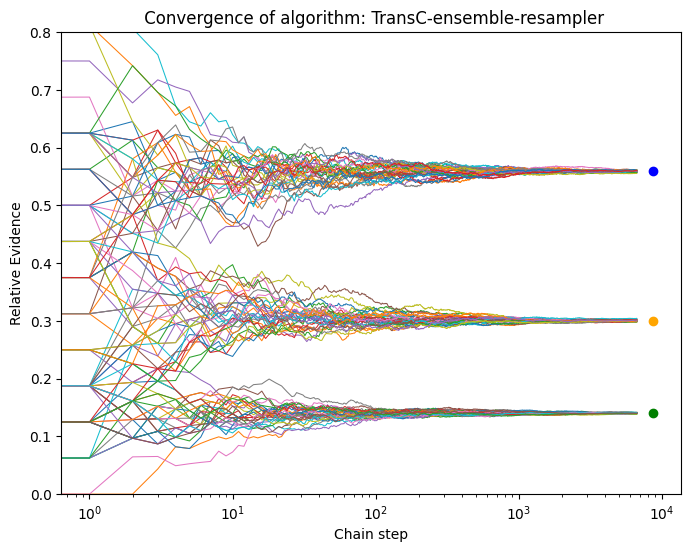

In [15]:
# plot relative number of visit to each state along the chain
if plotting:
    fig, axes = plt.subplots(figsize=(8, 6))
    if visits.ndim == 3:  # plot chains for each state and walker
        plt.semilogx(visits.reshape(np.shape(visits)[0], -1), lw=0.75)
    elif visits.ndim == 2:  # plot chains for each state average over walkers
        plt.semilogx(
            visits.reshape(np.shape(visits)[0], -1),
            lw=0.75,
            label=["State 1", "State 2", "State 3"],
        )
        plt.legend()
    plt.xlabel("Chain step")
    plt.ylabel("Relative Evidence")
    plt.plot(len(visits) * 1.3, trueML[0], "bo")
    plt.plot(len(visits) * 1.3, trueML[1], "o", color="orange")
    plt.plot(len(visits) * 1.3, trueML[2], "go")
    plt.title(" Convergence of algorithm: " + alg)
    plt.ylim(0.0, 0.8)

    # plt.savefig('convergence_ensemble_3-5-10.pdf')
    plt.show()

Coloured dots show the true relative normalization constants for each Gaussian. 

As you can see the chains of the Ensemble sampler have converged, because all chains are visiting each state in proportion to the correct normalization constants. 

If the pseudo-prior is not accurate enough it can cause bias in this sampling algorithm.

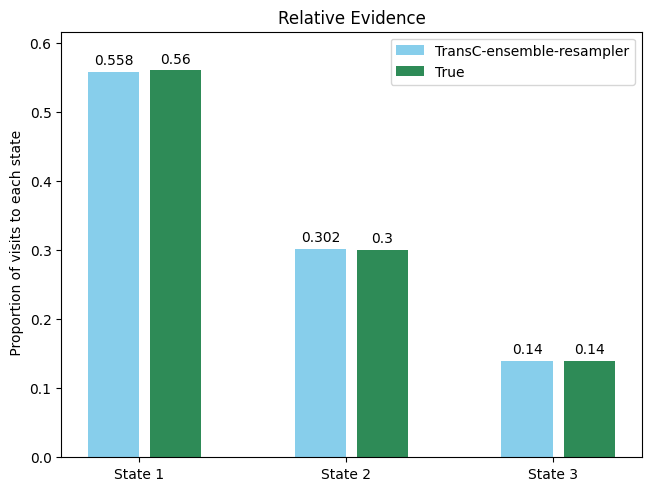

In [16]:
if plotting:
    # extract trans-D sample
    transc_ensemble = resample_ensembles(
        ensemble_per_state,
        relative_marginal_likelihoods,
        100_000,
    )

    h = np.zeros(nstates)
    h[list(Counter(states_chain.reshape(-1)).keys())] = list(
        Counter(states_chain.reshape(-1)).values()
    )
    h /= np.sum(h)

    # plot histogram of frequency of visits to each state

    labels = ("State 1", "State 2", "State 3")
    labels = ["State " + str(i + 1) for i in np.arange(nstates)]

    x = np.arange(nstates)  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout="constrained")
    offset = width * multiplier
    rects = ax.bar(x + offset, np.round(h, 3), width, label=alg, color="skyblue")
    ax.bar_label(rects, padding=3)
    multiplier += 1
    offset = width * multiplier + 0.05
    rects = ax.bar(
        x + offset, np.round(trueML, 3), width, label="True", color="seagreen"
    )
    ax.bar_label(rects, padding=3)
    multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(" Proportion of visits to each state")
    ax.set_title("Relative Evidence")
    ax.set_xticks(x + width / 2, labels)
    ax.legend(loc="upper right")
    ax.set_ylim(0.0, np.max(np.maximum(h, trueML)) * 1.1)
    # plt.savefig('Marginal_Likelihoods.png')
    plt.show()

 State;  0  in  3  dimensions
 State;  1  in  5  dimensions
 State;  2  in  10  dimensions


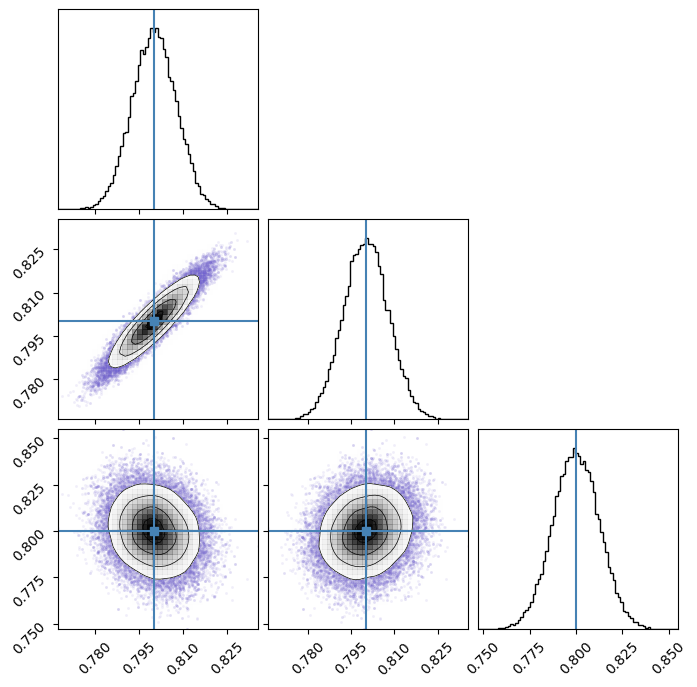

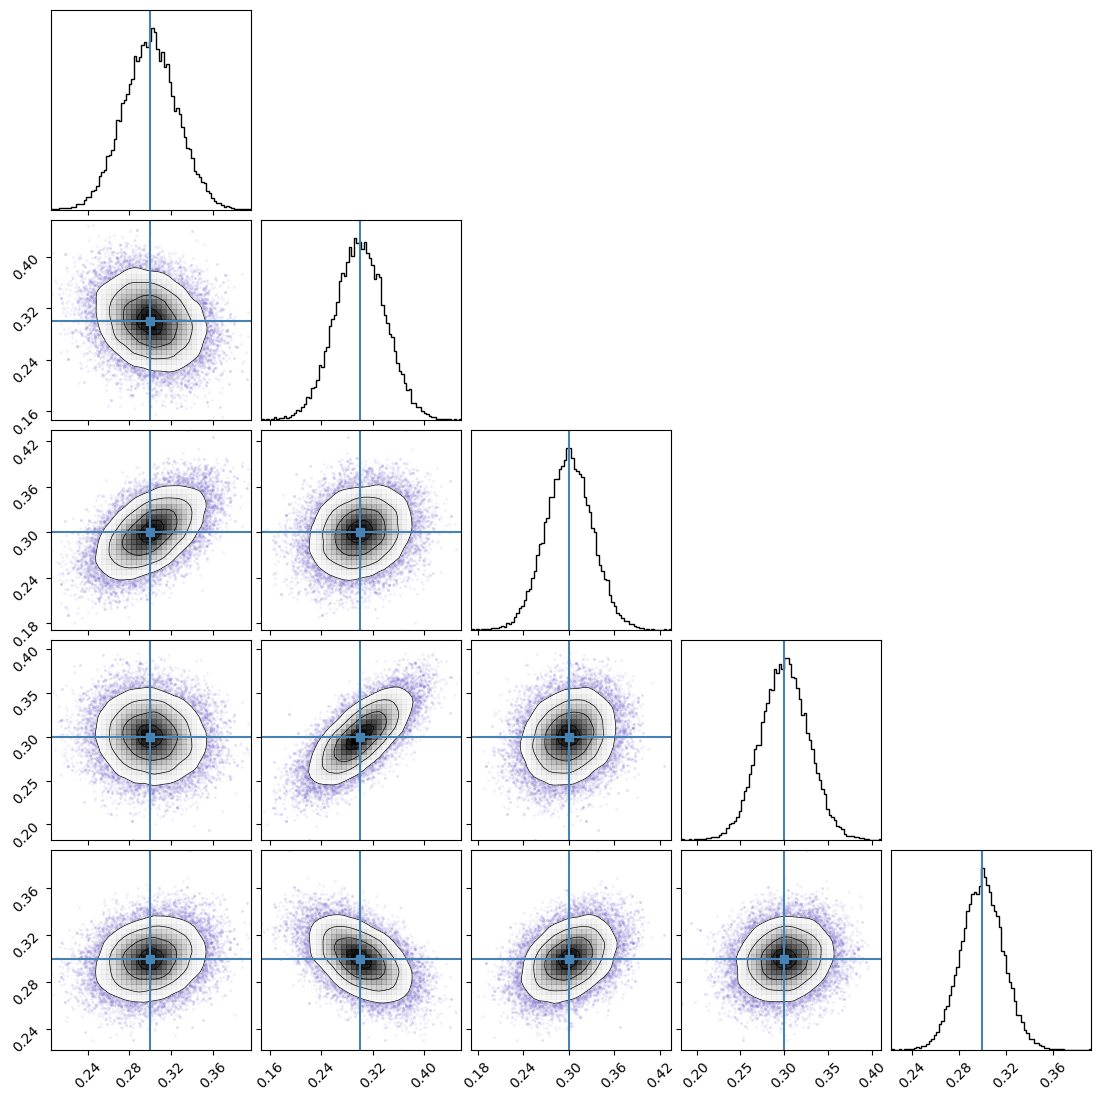

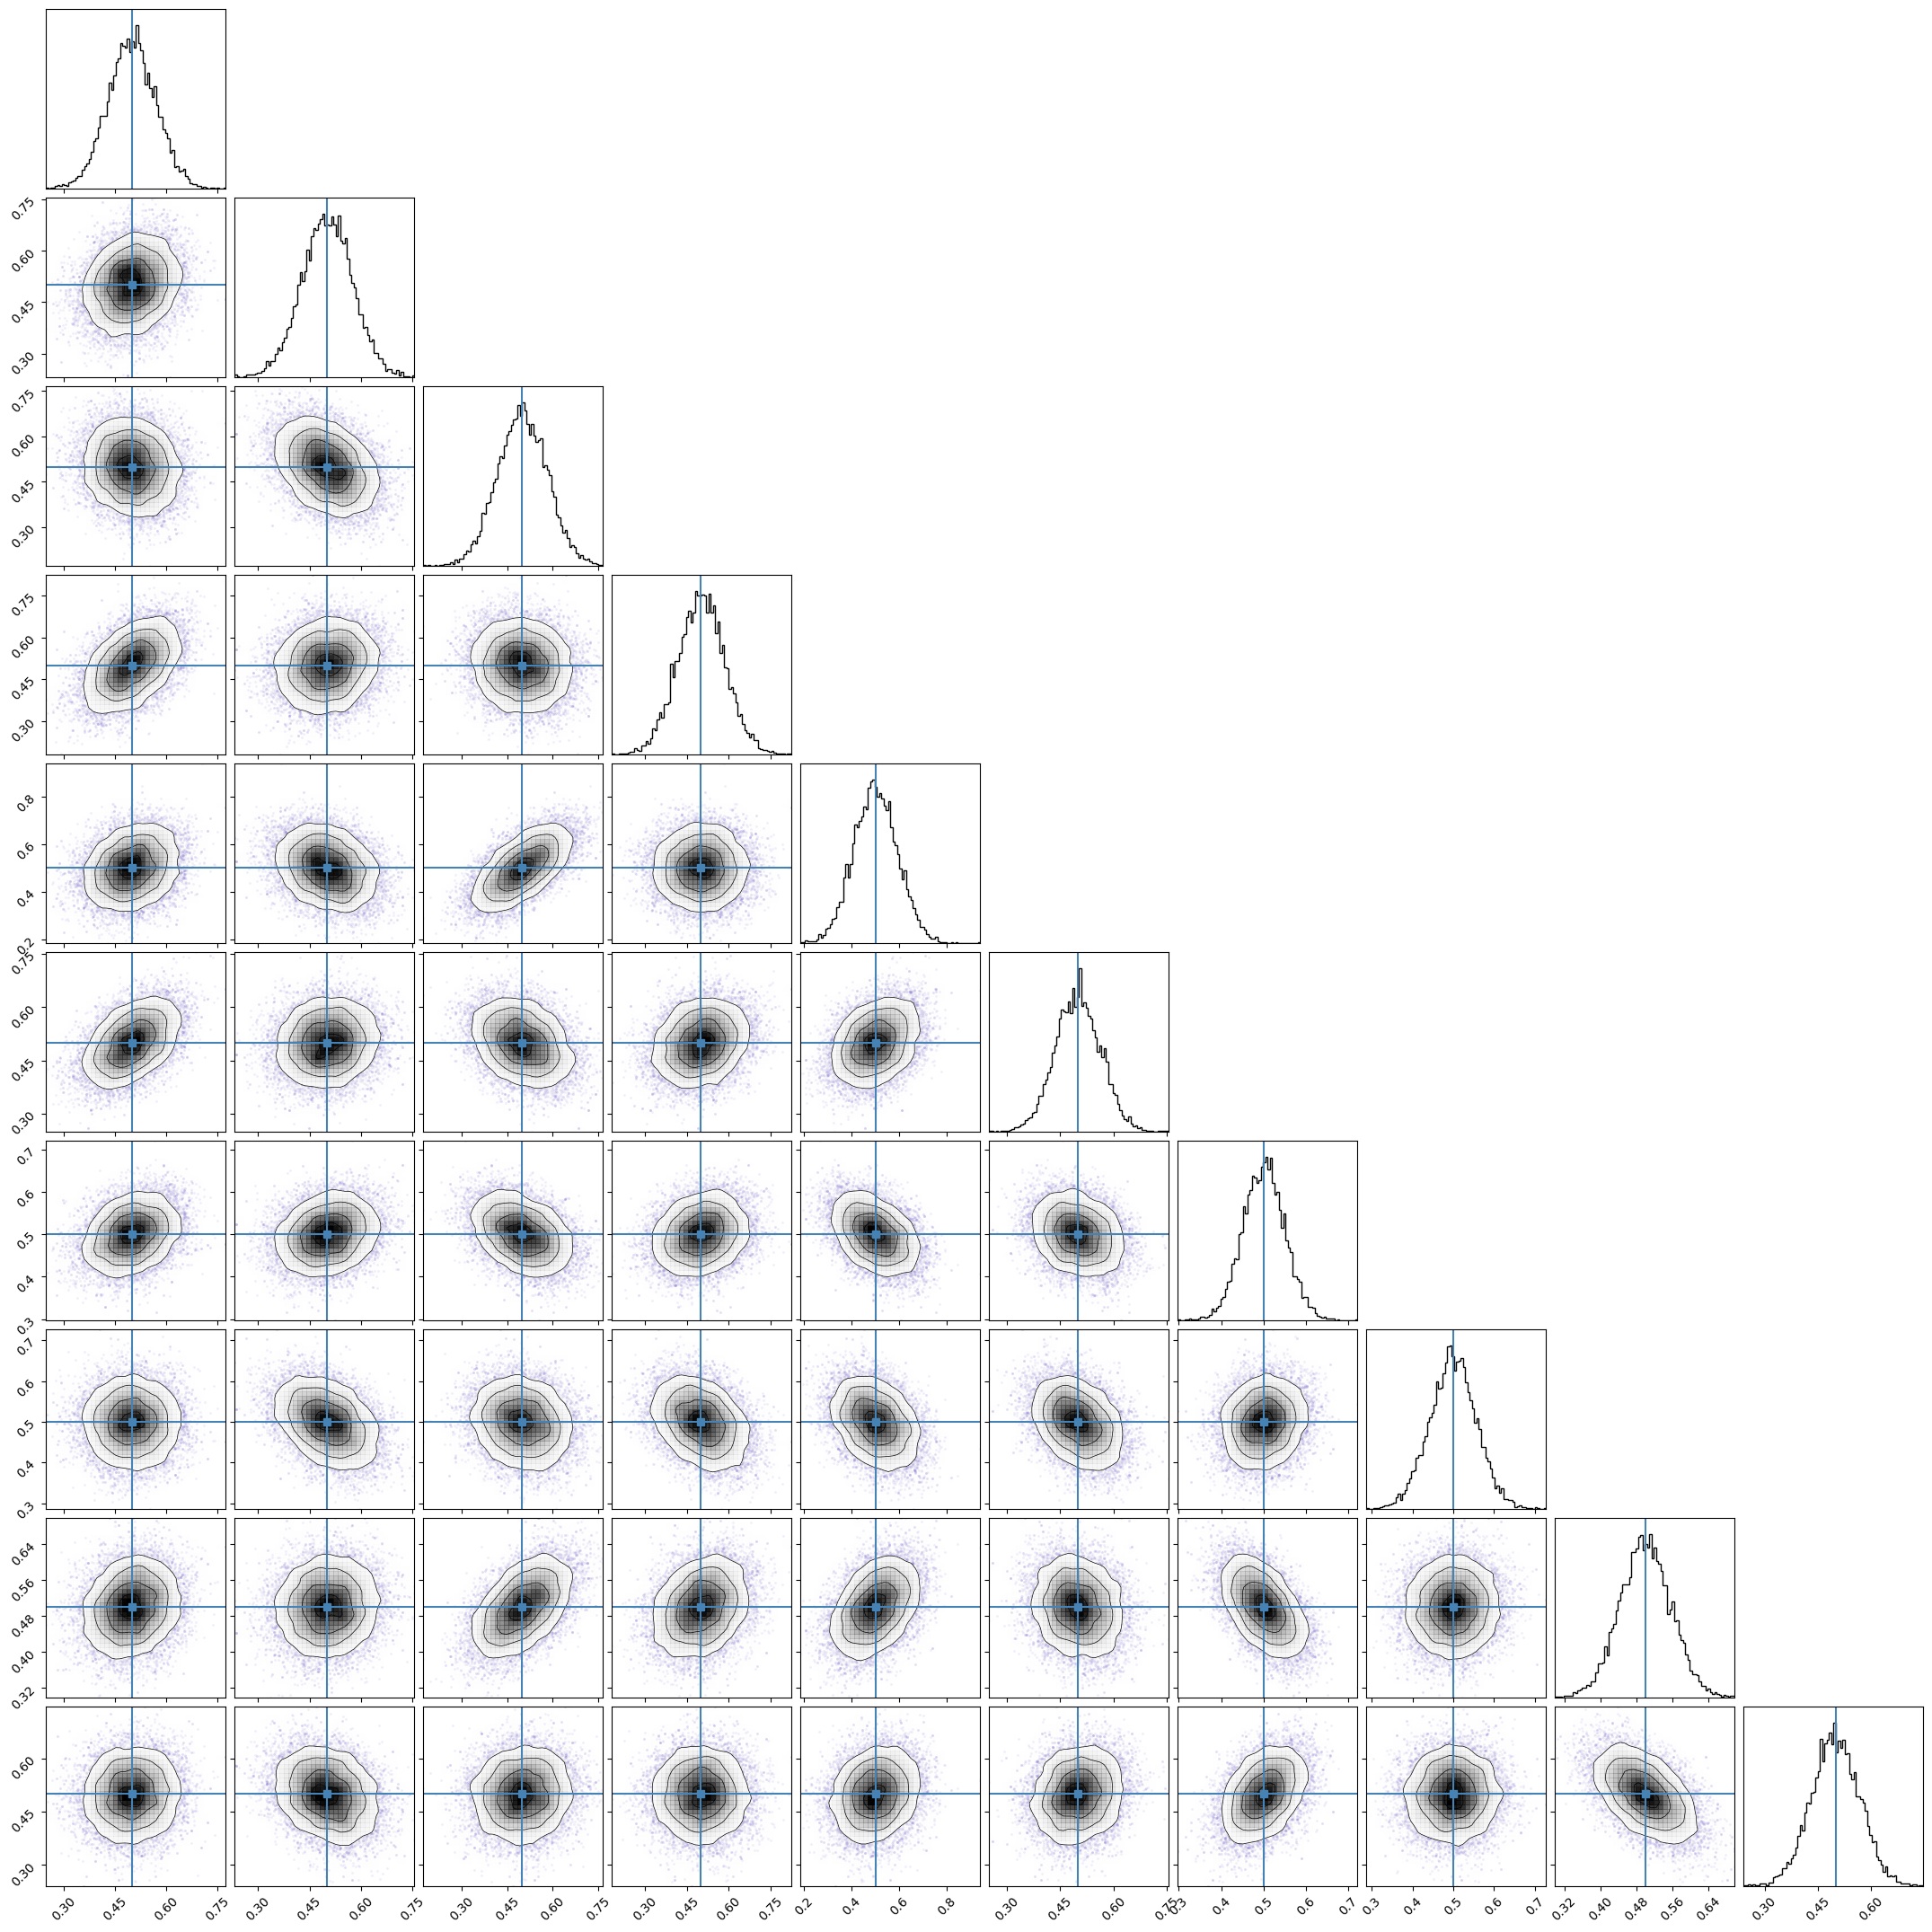

In [17]:
# corner plots to check sampling within each state
if plotting:
    for i in range(nstates):
        string = "State " + str(i)
        print(" State; ", i, " in ", ndims[i], " dimensions")
        fig = corner.corner(
            transc_ensemble[i],
            truths=mu[i],
            title=string,
            bins=40,
            hist_bin_factor=2,
            smooth=True,
            contour_kwargs=contour_kwargs,
            data_kwargs=data_kwargs,
        )

Density of within state samples looks reasonable.

In [18]:
print(
    f" Here is the Trans-C ensemble with\n {len(transc_ensemble[0])} samples in state 1\n {len(transc_ensemble[1])} samples in state 2\n {len(transc_ensemble[2])} samples in state 3\n",
    "\n",
    transc_ensemble,
)

 Here is the Trans-C ensemble with
 55777 samples in state 1
 30213 samples in state 2
 14010 samples in state 3
 
 [array([[0.80525537, 0.80181361, 0.78865149],
       [0.79879625, 0.79673712, 0.79379782],
       [0.80537322, 0.80632609, 0.80122072],
       ...,
       [0.8036134 , 0.80102207, 0.79022682],
       [0.78813176, 0.79059107, 0.82222148],
       [0.80485014, 0.8059245 , 0.79394383]], shape=(55777, 3)), array([[0.30963381, 0.36614446, 0.29884271, 0.32147369, 0.27697359],
       [0.3102938 , 0.3179433 , 0.32661301, 0.35058702, 0.32583834],
       [0.32858036, 0.27443619, 0.28477149, 0.34589116, 0.33279832],
       ...,
       [0.35923945, 0.28648136, 0.32809873, 0.27078052, 0.28540422],
       [0.27038465, 0.35349546, 0.27411592, 0.31807283, 0.27526227],
       [0.29177258, 0.32646214, 0.30210648, 0.28472834, 0.27532485]],
      shape=(30213, 5)), array([[0.49979925, 0.62389144, 0.42467078, ..., 0.52120123, 0.50118038,
        0.55702026],
       [0.4945545 , 0.49299663, 0.4

-------------------------------------------------------------------------------

### Example of using Laplace approximation

Here is an example of using the Laplace approximation to calculate evidence for each state using posterior ensembles.

In [19]:
(
    laplace_hessians,
    laplace_map_models,
    laplace_map_log_posteriors,
    laplace_log_marginal_likelihoods,
) = run_laplace_evidence_approximation(
    nstates,
    ndims,
    log_posterior=None,
    map_models=None,
    ensemble_per_state=ensemble_per_state,
    log_posterior_ens=log_posterior_ens,
)
tot = np.sum(np.exp(laplace_log_marginal_likelihoods))
print(
    " Estimated relative evidences                        :",
    *np.round((np.exp(laplace_log_marginal_likelihoods)) / tot, 8),
)

 Estimated relative evidences                        : 0.56164826 0.29866927 0.13968247
